<a href="https://colab.research.google.com/github/Geethik07/cloud-computing-project/blob/main/Project_snukala.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf spark-3.2.0-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.2.0-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, year, month
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.clustering import KMeans
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.ml.recommendation import ALS
import matplotlib.pyplot as plt

In [ ]:
file_path = "/content/customer_shopping_data.csv"
data = spark.read.csv(file_path, header=True, inferSchema=True)

In [ ]:
# Data Preprocessing
# Handle missing values and convert data types
data = data.na.drop()
data = data.withColumn("invoice_date", to_date(col("invoice_date"), "d/M/yyyy")) \
           .withColumn("age", col("age").cast("integer")) \
           .withColumn("quantity", col("quantity").cast("integer")) \
           .withColumn("price", col("price").cast("float")) \
           .withColumn("year", year(col("invoice_date"))) \
           .withColumn("month", month(col("invoice_date")))

In [ ]:
# Encode categorical columns (e.g., gender and category) for models
gender_indexer = StringIndexer(inputCol="gender", outputCol="gender_index")
data = gender_indexer.fit(data).transform(data)

In [ ]:
category_indexer = StringIndexer(inputCol="category", outputCol="category_index")
data = category_indexer.fit(data).transform(data)

In [ ]:
# Feature Engineering
assembler = VectorAssembler(inputCols=["age", "quantity", "price"], outputCol="features")
data = assembler.transform(data)

In [ ]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(data)
data = scaler_model.transform(data)

In [ ]:
# **Clustering (K-Means)**
kmeans = KMeans(featuresCol="scaledFeatures", k=4, seed=42)
kmeans_model = kmeans.fit(data)
data = kmeans_model.transform(data)

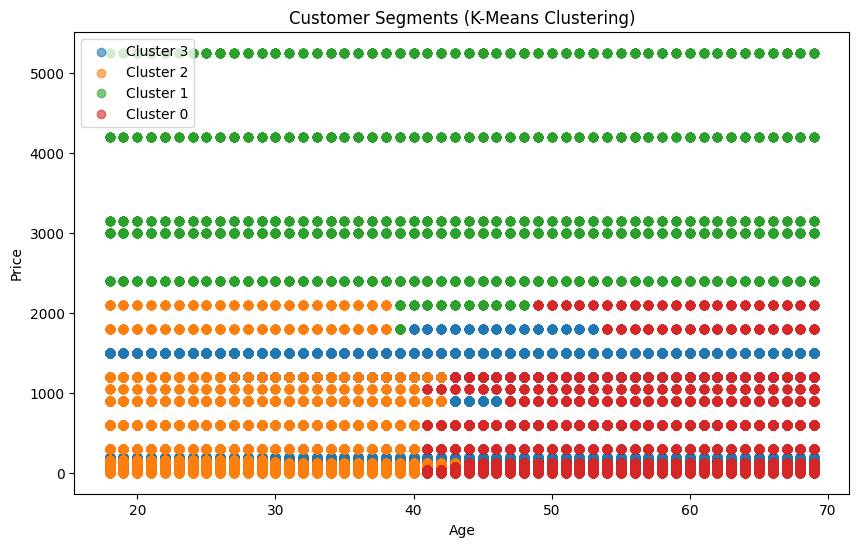

In [ ]:
# Plot clusters using a scatter plot
import numpy as np

cluster_data = data.select("age", "quantity", "price", "prediction").toPandas()

# Assign colors to each cluster
colors = np.array(["red", "blue", "green", "purple"])
plt.figure(figsize=(10, 6))

# Scatter plot with clusters
for cluster in cluster_data["prediction"].unique():
    cluster_points = cluster_data[cluster_data["prediction"] == cluster]
    plt.scatter(cluster_points["age"], cluster_points["price"],
                label=f"Cluster {cluster}", alpha=0.6)

plt.title("Customer Segments (K-Means Clustering)")
plt.xlabel("Age")
plt.ylabel("Price")
plt.legend()
plt.show()


In [ ]:
# **2. Classification (Logistic Regression)**
classification_data = data.drop("prediction")
assembler = VectorAssembler(inputCols=["age", "quantity", "price"], outputCol="classifier_features")
classification_data = assembler.transform(classification_data)

In [ ]:
lr = LogisticRegression(featuresCol="classifier_features", labelCol="gender_index")
lr_model = lr.fit(classification_data)
lr_predictions = lr_model.transform(classification_data)

In [ ]:
# Evaluate Logistic Regression
evaluator = MulticlassClassificationEvaluator(labelCol="gender_index", predictionCol="prediction", metricName="accuracy")
lr_accuracy = evaluator.evaluate(lr_predictions)
print(f"Logistic Regression Accuracy: {lr_accuracy * 100:.2f}%")

Logistic Regression Accuracy: 59.81%


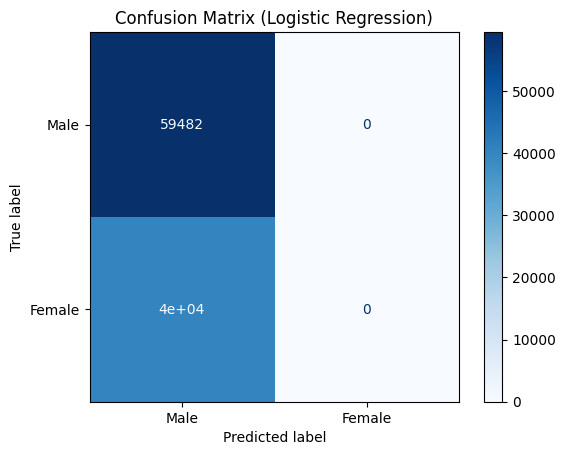

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert predictions to Pandas for visualization
predictions_df = lr_predictions.select("gender_index", "prediction").toPandas()

# Compute confusion matrix
cm = confusion_matrix(predictions_df["gender_index"], predictions_df["prediction"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Male", "Female"])

# Plot confusion matrix
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Logistic Regression)")
plt.show()


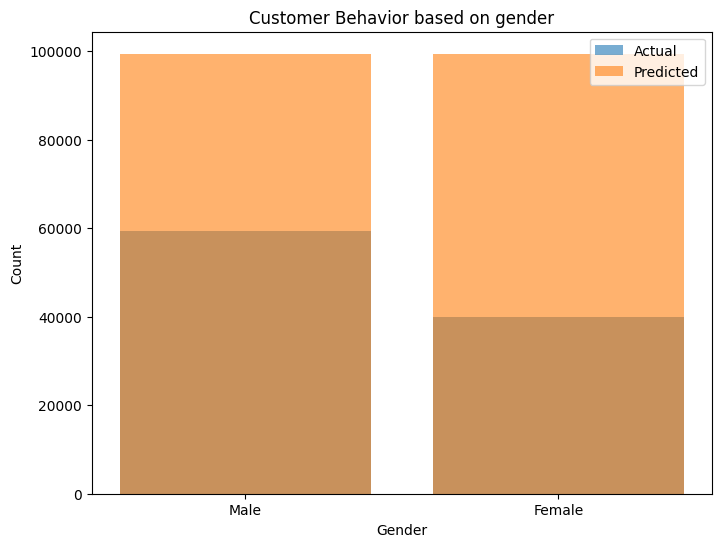

In [ ]:
# Group by actual and predicted classes
actual_counts = predictions_df["gender_index"].value_counts()
predicted_counts = predictions_df["prediction"].value_counts()

# Plot the comparison
plt.figure(figsize=(8, 6))
x_labels = ["Male", "Female"]

# Actual vs. Predicted Bar Chart
plt.bar(x_labels, actual_counts.sort_index(), alpha=0.6, label="Actual")
plt.bar(x_labels, predicted_counts.sort_index(), alpha=0.6, label="Predicted")
plt.title("Customer Behavior based on gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.legend()
plt.show()



In [ ]:
# **3. Regression (Spending Forecasting)**
regression_data = data.drop("prediction")
regressor = LinearRegression(featuresCol="classifier_features", labelCol="price")
regressor_model = regressor.fit(classification_data)
reg_predictions = regressor_model.transform(classification_data)

In [ ]:
# Evaluate Regression Model
reg_evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")
rmse = reg_evaluator.evaluate(reg_predictions)
print(f"Regression RMSE: {rmse:.20f}")

Regression RMSE: 0.00000000000021746726


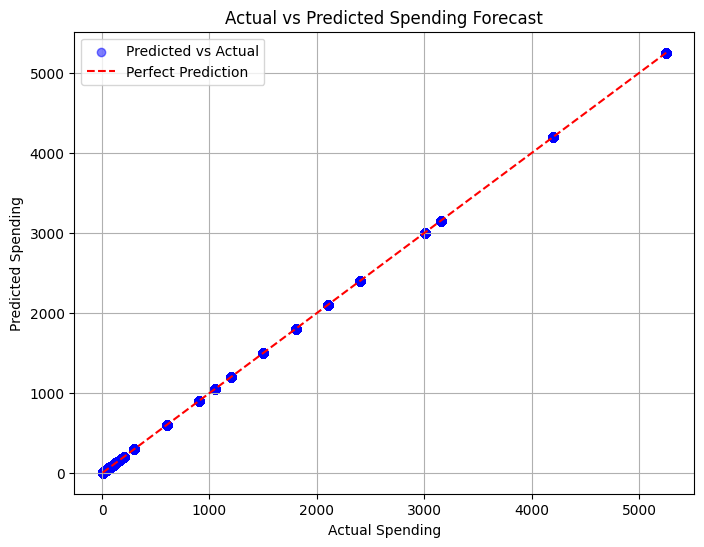

In [ ]:
# Scatter plot for actual vs. predicted spending
import matplotlib.pyplot as plt

# Convert regression predictions to Pandas DataFrame for plotting
reg_results = reg_predictions.select("price", "prediction").toPandas()

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(reg_results["price"], reg_results["prediction"], alpha=0.5, color="blue", label="Predicted vs Actual")
plt.plot([reg_results["price"].min(), reg_results["price"].max()],
         [reg_results["price"].min(), reg_results["price"].max()],
         color="red", linestyle="--", label="Perfect Prediction")

plt.title("Actual vs Predicted Spending Forecast")
plt.xlabel("Actual Spending")
plt.ylabel("Predicted Spending")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# **4. Recommendations (ALS)**
customer_indexer = StringIndexer(inputCol="customer_id", outputCol="customer_id_index")
data = customer_indexer.fit(data).transform(data)

In [ ]:
data = data.filter(col("price") > 0)

als_data = data.drop("prediction")

In [ ]:
# **Recommendation System (Collaborative Filtering)**
# ALS expects integer values for user and item columns, use StringIndexer if needed
als = ALS(userCol="customer_id_index", itemCol="category_index", ratingCol="price", coldStartStrategy="drop")
als_model = als.fit(als_data)

recommendations = als_model.recommendForAllUsers(5).toPandas()

/content/spark-3.2.0-bin-hadoop3.2/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
# Plot top recommendations for a sample user
sample_user = recommendations.iloc[0]
print(f"Top Recommendations for User {sample_user['customer_id_index']}:")
print(sample_user["recommendations"])

Top Recommendations for User 1:
[Row(category_index=4, rating=1200.3294677734375), Row(category_index=3, rating=10.872384071350098), Row(category_index=2, rating=2.125633716583252), Row(category_index=7, rating=-12.168167114257812), Row(category_index=5, rating=-12.233612060546875)]
